In [22]:
from pandas import Series, DataFrame
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

In [23]:
#Import 5D array
df_A = pd.read_csv('AEP_daily.csv')
df_A ['Datetime']= pd.to_datetime(df_A['Datetime'])
df_A = df_A.set_index('Datetime')

def series_to_array(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1] #reshape to  list
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

pasos = 5
x = series_to_array(df_A, pasos) #segments the data to with specific steps (array w x n-w)
x

,var1(t-5),var1(t-4),var1(t-3),var1(t-2),var1(t-1)
Datetime,,,,,
2004-10-06,14284.52174,12999.87500,12227.08333,14309.04167,14439.70833
2004-10-07,12999.87500,12227.08333,14309.04167,14439.70833,14424.79167
2004-10-08,12227.08333,14309.04167,14439.70833,14424.79167,14449.41667
2004-10-09,14309.04167,14439.70833,14424.79167,14449.41667,14350.33333
2004-10-10,14439.70833,14424.79167,14449.41667,14350.33333,12934.54167
...,...,...,...,...,...
2018-07-30,16503.33333,16474.25000,15816.62500,14113.08333,13658.00000
2018-07-31,16474.25000,15816.62500,14113.08333,13658.00000,15368.08333
2018-08-01,15816.62500,14113.08333,13658.00000,15368.08333,15180.29167


In [24]:
#Add dataframe to visulize data
df_A_copy = df_A.copy()
df_A_values = df_A_copy.drop(df_A_copy.index[0:pasos],axis=0) # to get same rows while graphing

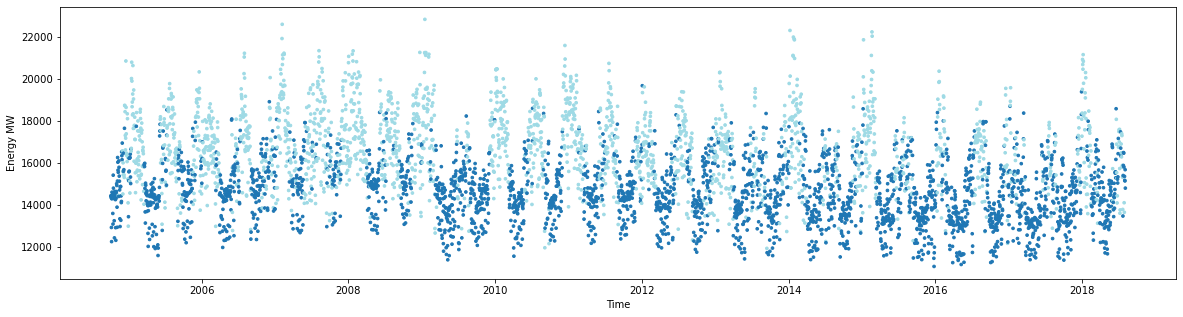

In [25]:
#Kmeans vizualization using PCA reduction
kmeans_AEP = KMeans(n_clusters = 2, random_state = 10).fit(x)

y_predict = kmeans_AEP.predict(x)

plt.figure(figsize=(20,5))
plt.scatter(df_A_values.index, df_A_values['AEP_MW'], c=y_predict, cmap='tab20', s=7)
plt.xlabel('Time')
plt.ylabel('Energy MW')
plt.show()

In [26]:
y_predict_df =pd.DataFrame(y_predict)
y_predict_df.columns = ['Clusters']

cluster = y_predict_df.groupby(['Clusters']).size()
cluster

Clusters
0    2919
1    2131
dtype: int64

In [27]:
scaler = StandardScaler()
AEP_s = scaler.fit_transform(x) #Standarize values to do not desprecite values

In [28]:
AEP_PCA = PCA()
AEP_PCA.fit(AEP_s) #Use PCA

AEP_PCA.explained_variance_ratio_ #To visualize which columns are more significant

array([0.7627629 , 0.14095688, 0.06470385, 0.02340422, 0.00817215])

In [29]:
AEP_PCA = PCA(n_components = 2)
AEP_PCA.fit(AEP_s) #Adjust to 2D
AEP_PCA

PCA(n_components=2)

In [30]:
AEP_results = AEP_PCA.transform(AEP_s) #Values of 2D
AEP_results

array([[-2.13288558, -0.33542382],
       [-2.05946719, -0.89348642],
       [-1.70427633, -0.64826049],
       ...,
       [-0.79805107, -0.10150448],
       [-0.906275  , -0.63079885],
       [-0.54122417, -0.52011301]])

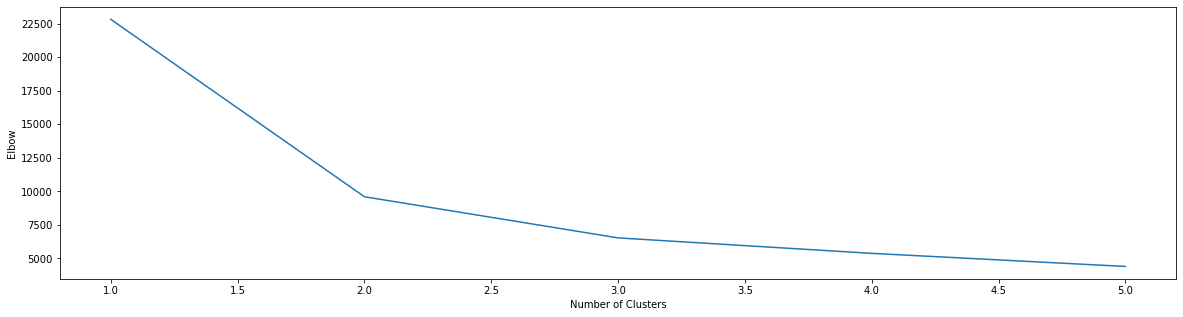

In [31]:
Elbow = []
for i in range(1,6):
    kmeans_AEP_PCA = KMeans(n_clusters = i, init ='k-means++', random_state = 10)
    kmeans_AEP_PCA.fit(AEP_results)
    Elbow.append(kmeans_AEP_PCA.inertia_)

plt.figure(figsize=(20,5))
plt.plot(range(1,6), Elbow)
plt.xlabel('Number of Clusters')
plt.ylabel('Elbow')
plt.show()

In [32]:
#Visualize 2D array values in a dataframe
x_PCA = pd.DataFrame(AEP_results)
x_PCA.columns = ['One', 'Two']
x_PCA

,One,Two
0,-2.132886,-0.335424
1,-2.059467,-0.893486
2,-1.704276,-0.648260
3,-1.249738,-0.012830
4,-1.544019,0.439994
...,...,...
5045,-0.199305,1.327116
5046,-0.510600,0.793709
5047,-0.798051,-0.101504
5048,-0.906275,-0.630799


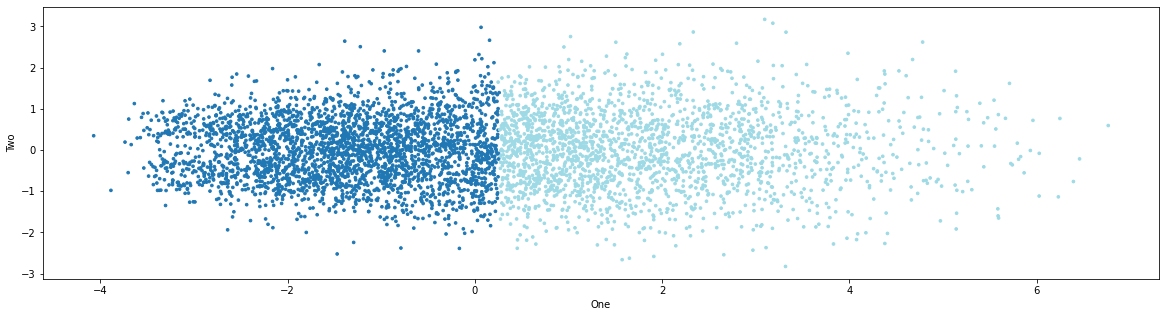

In [33]:
#Visualize PCA
plt.figure(figsize=(20,5))
plt.scatter(x_PCA['One'], x_PCA['Two'], c=y_predict, cmap='tab20', s=7)
plt.xlabel('One')
plt.ylabel('Two')
plt.show()